# Real or Not? NLP with Disaster Tweets

O Twitter é uma das redes sociais mais importantes atualmente, além de ser usado por diversas celebridades e pessoas comuns como uma forma rápida de atualizar seus seguidores sobre seu dia-a-dia, se tornou também uma grande mídia para atualização de notícias e comunicar emergências, já que pode alcançar milhares de pessoas do mundo todo em apenas segundos.

O [Kaggle](https://www.kaggle.com) traz o um desafio para quem quer testar seus conhecimentos em linguagem natural (NLP), tendo que descobrir qual tweet está alertando sobre uma emergência ou algum desastre e quais não, todas as informações podem ser encontradas [aqui](https://www.kaggle.com/c/nlp-getting-started).

Os arquivos do Glove são grandes demais para o GitHub, para consegui-lo acesse: https://github.com/stanfordnlp/GloVe

Meus objetivos nesse notebook são:

- Preparar os dados usando o Glove e Word2vec para a rede neural;
- Treinar o modelo para a predição;
- Validação;

## Importando bibliotecas

In [1]:
#Básicas
import pandas as pd
import numpy as np

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Gensim usado para transformar arquivos externos em Word2vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

#Usado para Processamento de Linguagem
import nltk

#Usado para pegar a lista de pontuações
import string

#Para construir Nuvens de Palavras
from wordcloud import WordCloud

#Rede Neural Keras
from tensorflow import keras

#Biblioteca para medir quanto se preve de cada classe
from sklearn.metrics import classification_report

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Neste projeto irei apenas utilizar os textos para prever se um tweet é uma emergência ou não.

A proporção das classes é bem próxima.

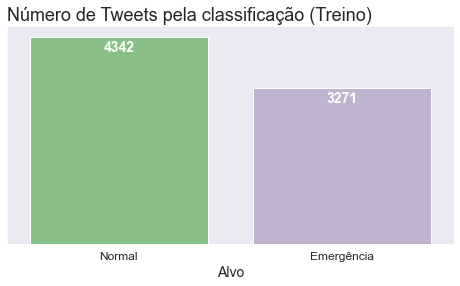

In [5]:
sns.set_palette('Accent')
sns.set_style('dark')

plt.figure(figsize=(8, 4))
ax = sns.countplot(train['target'])

plt.title('Número de Tweets pela classificação (Treino)', fontsize=18, loc='Left')
ax.set_xlabel('Alvo', fontsize=14)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_xticklabels(['Normal', 'Emergência'], fontsize=12)


labels = (train['target'].value_counts())
for i, v in enumerate(labels):
    ax.text(i, v-300, str(v), horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

Juntando os datasets de treino e teste apenas para fazer algumas análises.

In [6]:
train_test = pd.concat([train, test], keys=[1, 2], axis=0)

Aqui eu crio o corpus, ele recebe todos os textos de uma vez. Também criei o nuvem de palavras.

In [7]:
corpus = ' '.join([palavra for palavra in train_test['text']])

nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110, collocations=False)
nuvem_palavras.generate(corpus)

Aqui a nuvem de palavras com todas as palavras sem tratamento, é possivel ver algumas palavras em relação a emergência que já se destacam.

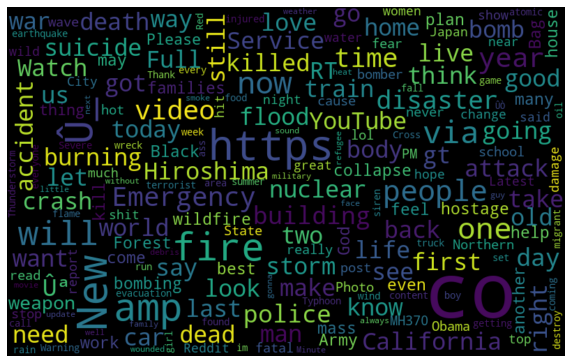

In [8]:
plt.figure(figsize=(10, 7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')
plt.show()

Criei uma função para pegar as palavras mais frequêntes. E é possivel ver que tem muita pontuação e stopwords (são palavras irrelevantes para o sentido do texto), como esperado do Twitter as "#s" e "@s" são muito presentes.

In [9]:
def frequencia(texto):
    token = nltk.word_tokenize(texto)
    frequencia = nltk.FreqDist(token)
    df_frequencia = pd.DataFrame({'Palavra': list(frequencia.keys()),
                                  'Frequencia': list(frequencia.values())})

    return df_frequencia.nlargest(columns='Frequencia', n=10)
    
frequencia(corpus)

,Palavra,Frequencia
192,:,9636
204,http,6157
7,#,4946
161,?,4458
20,.,4306
199,@,4039
3,the,3646
57,a,2650
25,to,2628
27,in,2523


Pegando as stopwords e adicionando mais três palavras que não serão retiradas por nenhum recurso que usei.

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['http', '...', 'https']

O "Tokanizador", é uma função que criei para usar o word_tokenize do NLTK, ele serve para separar as palavras da pontuação, aproveitando disso já usei o string.punctuation para retirar as pontuações e retirei as stopwords também.

In [11]:
def tokenizador(texto):
    texto = texto.lower()
    lista_sem_pontuacao = []
    
    for token in nltk.word_tokenize(texto):
        if token not in string.punctuation:
            if token not in stopwords:
                lista_sem_pontuacao.append(token)
    
    return lista_sem_pontuacao

Aqui vou fazer a nuvem de palavras apenas dos tweets que são emergência ou desastres.

In [12]:
desastre = train.query('target==1')['text']
corpus_desastre = ' '.join([palavra for palavra in desastre])
corpus_desastre = tokenizador(corpus_desastre)
corpus_desastre = ' '.join([palavra for palavra in corpus_desastre])

Na nuvem de palavras é possível ver coisas como: fire (fogo), killed (morto), police (polícia), Hiroshima e etc.

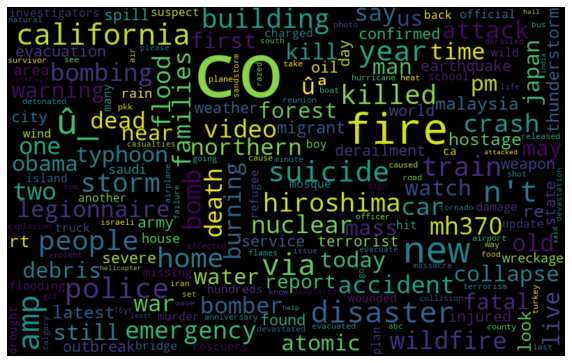

In [13]:
nuvem_palavras.generate(corpus_desastre)

plt.figure(figsize=(10, 7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')
plt.show()

A frequência mostra que exatamente o que vimos na nuvem de palavras, fire, police e news (notícias), são algumas das mais frequentes.

In [14]:
frequencia(corpus_desastre)

,Palavra,Frequencia
64,'s,276
8,fire,177
116,news,140
535,amp,135
428,via,121
375,n't,120
48,disaster,118
28,california,111
138,police,106
25,people,104


Agora a nuvem de palavras de tweets comuns.

In [15]:
nao_desastre = train.query('target==0')['text']
corpus_nao_desastre = ' '.join([palavra for palavra in nao_desastre])
corpus_nao_desastre = tokenizador(corpus_nao_desastre)
corpus_nao_desastre = ' '.join([palavra for palavra in corpus_nao_desastre])

Da para perceber algumas palavras como: Youtube, good (bom), great (ótimo), video, reddit (rede social), time (tempo) e etc.

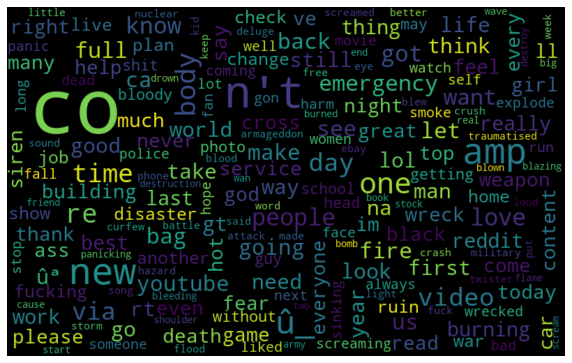

In [16]:
nuvem_palavras.generate(corpus_nao_desastre)

plt.figure(figsize=(10, 7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis('off')
plt.show()

Na frequência se nota que a palavra "like" aparece muito também.

In [17]:
frequencia(corpus_nao_desastre)

,Palavra,Frequencia
0,'s,517
18,n't,326
26,like,253
181,amp,209
153,'m,203
52,new,164
109,get,162
341,one,129
575,body,111
175,would,104


Glove é um modelo pré-treinado, onde vectoriza as palavras isso faz com que palavras parecidas se aproximem. Mais informações no link: https://nlp.stanford.edu/projects/glove/

In [18]:
glove_file = datapath('glove.6B.300d.txt')
tmp_file = get_tmpfile('word2vev.6B.300d.txt')

_ = glove2word2vec(glove_file, tmp_file)

modelo_w2v = KeyedVectors.load_word2vec_format(tmp_file)

Um exemplo é que se procurarmos por "dados", iremos encontrar palavras próximas como: informação, base de dados, análise, computado e etc.

In [19]:
modelo_w2v.most_similar('data')

[('information', 0.6632627844810486),
 ('database', 0.5932749509811401),
 ('analysis', 0.585267186164856),
 ('statistics', 0.5523297190666199),
 ('computer', 0.5270313024520874),
 ('tracking', 0.5189864039421082),
 ('databases', 0.5159896612167358),
 ('survey', 0.5035285949707031),
 ('software', 0.49450206756591797),
 ('analyzing', 0.49001699686050415)]

Agora algumas funções para descobrir os vetores das palavras dos nossos tweets:
- combinacao_vetores: busca os vetores das palavras e as combina, como cada palavra dos vetores tem 300 atributos iniciamos com isso e substituimos, se uma palavra do tweet não existir no Glove ela será substituida por "unk".
- matriz_vetores: faz as coisas funcionarem, inicia a matriz a faz o tokenizador e a combinacao_vetores para cada palavra.

In [20]:
def combinacao_vetores(palavras_numeros):
    vetor_resultante = np.zeros(300)
    
    for pn in palavras_numeros:
        try:
            vetor_resultante += modelo_w2v.get_vector(pn)
        except KeyError:
            vetor_resultante += modelo_w2v.get_vector('unk')
    
    return vetor_resultante

def matriz_vetores(textos):
    x = len(textos)
    y = 300
    matriz = np.zeros((x, y))
    
    for i in range(x):
        palavras_numeros = tokenizador(textos.iloc[i])
        matriz[i] = combinacao_vetores(palavras_numeros)
        
    return matriz

Arrumando os dados de traino e teste.

In [21]:
glove_train = matriz_vetores(train['text'])
y_train = train['target']
glove_test = matriz_vetores(test['text'])

## Rede Neural

Irei usar o Keras para construir uma simples e pequena rede neural, após meus diversos testes essa foi a mais estável delas. Com uma camada de Dropout e função de ativação Sigmoid, otimizador Adam, 500 épocas e tamanho de batch 16.

In [22]:
rede_neural = keras.Sequential([
    keras.layers.Flatten(input_shape=(300,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

rede_neural.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
historico = rede_neural.fit(glove_train, y_train, epochs=500, validation_split=0.2, batch_size=16, shuffle=True, verbose=0)

Como pode-se ver no gráfico acurácia e a perda se manteram proximas no treino e validação.

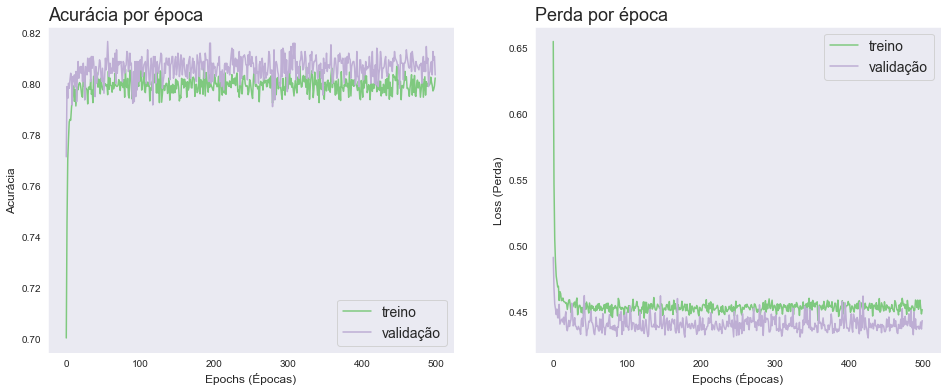

In [23]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])
plt.title('Acurácia por época', fontsize=18, loc='left')
plt.xlabel('Epochs (Épocas)', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.legend(['treino', 'validação'], prop={'size': 14})

plt.subplot(1, 2, 2)

plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('Perda por época', fontsize=18, loc='left')
plt.xlabel('Epochs (Épocas)', fontsize=12)
plt.ylabel('Loss (Perda)', fontsize=12)
plt.legend(['treino', 'validação'], prop={'size': 14})

In [24]:
print(f'Acurácia de treino: {historico.history["accuracy"][-1]:0.3f}')
print(f'Acurácia da validação: {historico.history["val_accuracy"][-1]:0.3f}')

Acurácia de treino: 0.802
Acurácia da validação: 0.804


Aqui fiz a previsão usando os dados de teste para que possa fazer a classificação dos resultados. A rede neural retorna os valores de acordo o quão proximo está da classificação. Por exemplo os tweets que serão classificados como 1 (emergência), estarão mais próximos do 1, e os tweets normais mais próximos de 0, sendo o 0.5 o meio disso e usamos ele para classificar.

In [25]:
y_pred = rede_neural.predict(glove_train)
y_pred = [1 if x > 0.5 else 0 for x in y_pred]

A precisão com os tweets que são emergências ou desastres e dos normais.

In [26]:
precisao = classification_report(y_train, y_pred)
print(precisao)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4342
           1       0.79      0.76      0.78      3271

    accuracy                           0.81      7613
   macro avg       0.81      0.80      0.81      7613
weighted avg       0.81      0.81      0.81      7613



Aqui decidi fazer um teste com duas frases que eu escrevi.

Na primeira um tweet normal falando que estou trabalhando em meus projetos de data science e machine learning.

Na segunda falo que o fogo está queimando a floresta Amazônica.

E como a explicado antes o primeiro está muito próximo do 0 então ele tem certeza que não é uma emergêncie e realmente não é. Já o segundo está acima de 0.5 oque já é acerto mesmo não estando tão perto de 1.

In [27]:
testando = pd.Series(['I am working in my data science and machine learning projects.',
                      'The fire is burning the Amazon forest.'])
testando = matriz_vetores(testando)
rede_neural.predict(testando)

array([[0.09123679],
       [0.72153574]], dtype=float32)

E aqui gero o arquivo para enviar ao Kaggle.

In [28]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['target'] = rede_neural.predict(glove_test)
submission['target'] = [1 if x>0.5 else 0 for x in submission['target']]
submission.to_csv('nn_keras_v1.csv', index=False)